# Import Library

In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, accuracy_score

# Data Load

In [2]:
def load_data(fold_no) :
    train_sw_iou = pd.read_csv('./iou/train_sw_iou(fold{}).csv'.format(fold_no), header=None)
    train_nsw_iou = pd.read_csv('./iou/train_nsw_iou(fold{}).csv'.format(fold_no), header=None)

    test_sw_iou = pd.read_csv('./iou/test_sw_iou(fold{}).csv'.format(fold_no), header=None)
    test_nsw_iou = pd.read_csv('./iou/test_nsw_iou(fold{}).csv'.format(fold_no), header=None)
    
    train_iou = pd.concat([train_sw_iou, train_nsw_iou], axis=0)
    test_iou = pd.concat([test_sw_iou, test_nsw_iou], axis=0)

    train_x = np.array(train_iou)
    test_x = np.array(test_iou)
    
    train_y = np.array([1]*len(train_sw_iou) + [0]*len(train_nsw_iou))
    test_y = np.array([1]*len(test_sw_iou) + [0]*len(test_nsw_iou))
    
    # shuffle
    s = np.arange(train_x.shape[0])
    np.random.shuffle(s)

    train_x = train_x[s]
    train_y = train_y[s]
    
    return train_x, train_y, test_x, test_y

# Training

In [3]:
def classification_optimal_thres(scores, threshold):
    pred = []
    for s in scores:
        if s > threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

* cross validation

----- Fold 1 ------
AUC:  0.9737674465307762
Accuracy: 0.9388264669163545


              precision    recall  f1-score   support

   non-smile       0.91      0.97      0.94       368
       smile       0.97      0.91      0.94       433

    accuracy                           0.94       801
   macro avg       0.94      0.94      0.94       801
weighted avg       0.94      0.94      0.94       801

----- Fold 2 ------
AUC:  0.9848378351240085
Accuracy: 0.9438202247191011


              precision    recall  f1-score   support

   non-smile       0.92      0.96      0.94       368
       smile       0.97      0.93      0.95       433

    accuracy                           0.94       801
   macro avg       0.94      0.95      0.94       801
weighted avg       0.94      0.94      0.94       801

----- Fold 3 ------
AUC:  0.9326502113526569
Accuracy: 0.87625


              precision    recall  f1-score   support

   non-smile       0.85      0.89      0.87       368
       smile       0

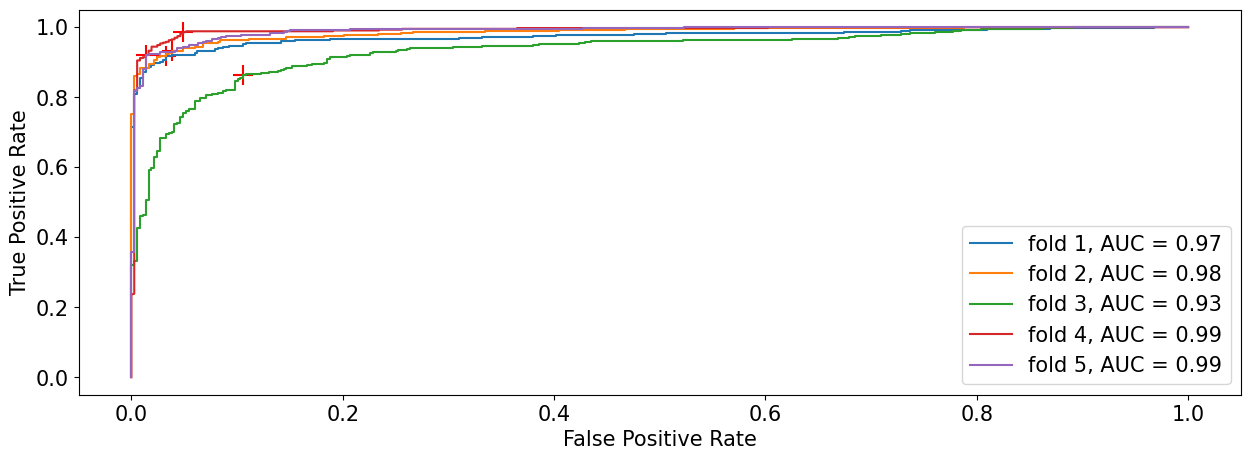

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 93.55090004046882 (+- 3.131215702047831)


In [16]:
plt.rc('font', size=15)
plt.figure(figsize=(15,5))

acc_list = []
for fold_no in range(1,6) :
    train_x, train_y, test_x, test_y = load_data(fold_no)
    
    clf = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 10,
                                min_samples_leaf = 8,
                                min_samples_split = 16,
                                random_state = 0,
                                n_jobs = -1)
    clf.fit(train_x, train_y)
    joblib.dump(clf, "RF_model/RF_fold-{}.joblib".format(fold_no))
    
    y_prob = clf.predict_proba(test_x) 
    y_pred = clf.predict(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, y_prob[:,1])
    auc_value = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr-fpr)
    optimal_trhd = thresholds[optimal_idx]
    sens, spec = tpr[optimal_idx], 1-fpr[optimal_idx]
    
    y_pred_opt = classification_optimal_thres(y_prob[:,1], optimal_trhd)
    acc_list.append(accuracy_score(list(test_y), y_pred_opt)*100)
    
    print("----- Fold {} ------".format(fold_no))
    print("AUC: ", auc_value)
    print("Accuracy: "+str(accuracy_score(list(test_y), y_pred_opt)))
    print('\n')
    print(classification_report(test_y, y_pred_opt, target_names=['non-smile', 'smile']))
    
    plt.plot(fpr, tpr, label='fold {}, AUC = {:.2f}'.format(fold_no
                                                            , roc_auc_score(y_true=test_y, y_score=y_prob[:,1])))
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='+', s=200, color='r')
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_list)} (+- {np.std(acc_list)})')

# Feature importance

* Feature importance based on mean decrease in impurity


[0.13813013 0.05406274 0.03765968 0.01397613 0.02361941 0.43508708
 0.1789417  0.11852312] [0.13414484 0.07130367 0.05249903 0.00846329 0.02233686 0.23389465
 0.18328562 0.14816918]


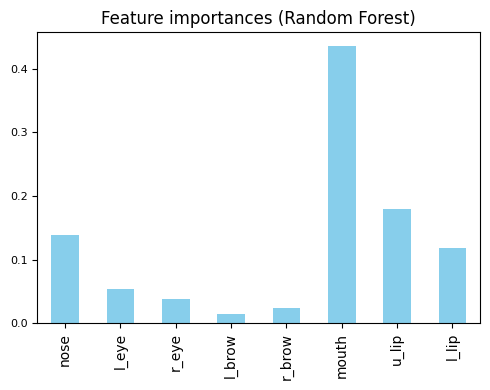

C:\Users\USER\anaconda3\envs\tf26_py38\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\USER\AppData\Local\Temp\joblib_memmapping_folder_23392_dafa6a08a7a7427b876f3e9026e8f03f_16107b20cc624c0ab93fb030ef0f5bb8
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\USER\anaconda3\envs\tf26_py38\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\USER\AppData\Local\Temp\joblib_memmapping_folder_23392_dafa6a08a7a7427b876f3e9026e8f03f_7c0230ab028e403dbcbe485ba03c5dd2
  warnings.warn("Failed to delete temporary folder: {}"


In [36]:
target_fold_no = 4
feature_names = ['nose', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'mouth', 'u_lip', 'l_lip']
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for fold_no in range(1,6) :
    if fold_no == 4 :
        train_x, train_y, test_x, test_y = load_data(fold_no)

        clf = RandomForestClassifier(n_estimators = 100, 
                                    max_depth = 10,
                                    min_samples_leaf = 8,
                                    min_samples_split = 16,
                                    random_state = 0,
                                    n_jobs = -1)
        clf.fit(train_x, train_y)
        
        importances = clf.feature_importances_
        
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        print(importances, std)
        forest_importances = pd.Series(importances, index=feature_names)
        
        
        fig, ax = plt.subplots(figsize=(5, 4))
#         forest_importances.plot.bar(yerr=std, ax=ax, color='skyblue')
        forest_importances.plot.bar(ax=ax, color='skyblue')
        ax.set_title("Feature importances (Random Forest)")
        fig.tight_layout()
        

* Feature importance based on feature permutation

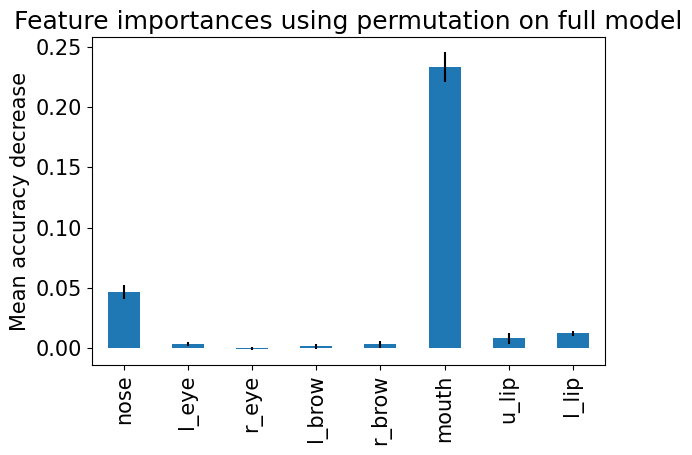

In [14]:
from sklearn.inspection import permutation_importance

target_fold_no = 4
feature_names = ['nose', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'mouth', 'u_lip', 'l_lip']

for fold_no in range(1,6) :
    if fold_no == 4 :
        train_x, train_y, test_x, test_y = load_data(fold_no)

        clf = RandomForestClassifier(n_estimators = 100, 
                                    max_depth = 10,
                                    min_samples_leaf = 8,
                                    min_samples_split = 16,
                                    random_state = 0,
                                    n_jobs = -1)
        clf.fit(train_x, train_y)
        
        result = permutation_importance(
            clf, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2
        )

        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
        ax.set_title("Feature importances using permutation on full model")
        ax.set_ylabel("Mean accuracy decrease")
        fig.tight_layout()
        plt.show()